In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(
    font_scale=2,
    style="whitegrid", 
    rc={'figure.figsize':(20,10)})

# 0 Context

This [Kaggle dataset](https://www.kaggle.com/mursideyarkin/mobile-games-ab-testing-cookie-cats) includes A/B-test results of **Cookie Cats** to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate30 or gate40.

Let's explore and preprocess data, conduct A/B-test.

In [2]:
ab_cats = pd.read_csv('cookie_cats.csv')
ab_cats.head()

userid  version  sum_game_rounds  retention_1  retention_7
0     116  gate_30                3        False        False
1     337  gate_30               38         True        False
2     377  gate_40              165         True        False
3     483  gate_40                1        False        False
4     488  gate_40              179         True         True

The data we have is from 90,189 players that installed the game while the A/B-test was running. The variables are:

* `userid` - A unique number that identifies each player.
* `version` - Whether the player was put in the control group (gate30 - a gate at level 30) or in the group with the moved gate (gate40 - a gate at level 40).
* `sum_game_rounds` - the number of game rounds played by the player during the first 14 days after an install.
* `retention_1` - Did the player come back and play 1 day after installing?
* `retention_7` - Did the player come back and play 7 days after installing?

# 1 EDA

In [3]:
ab_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   userid           90189 non-null  int64 
 1   version          90189 non-null  object
 2   sum_game_rounds  90189 non-null  int64 
 3   retention_1      90189 non-null  bool  
 4   retention_7      90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Are there duplicated rows in the dataframe?

In [4]:
ab_cats[ab_cats.duplicated(keep=False)]

Empty DataFrame
Columns: [userid, version, sum_game_rounds, retention_1, retention_7]
Index: []

## 1.1 Summary stats

In [5]:
# Target stats
ab_cats.describe()[['sum_game_rounds']].T

count       mean         std  min  25%   50%   75%      max
sum_game_rounds  90189.0  51.872457  195.050858  0.0  5.0  16.0  51.0  49854.0

Summary stats by groups

In [6]:
# Control and Test Groups stats
ab_cats.groupby('version') \
       .agg({'sum_game_rounds': ['count', 'median', 'mean', 'std', 'min', 'max']})

sum_game_rounds                                         
                  count median       mean         std min    max
version                                                         
gate_30           44700     17  52.456264  256.716423   0  49854
gate_40           45489     16  51.298776  103.294416   0   2640

In [7]:
# In retention dimensions
ab_cats.groupby(['version', 'retention_1', 'retention_7']) \
       .agg({'sum_game_rounds': ['count', 'median', 'mean', 'std', 'min', 'max']})

sum_game_rounds                     \
                                          count median        mean   
version retention_1 retention_7                                      
gate_30 False       False                 22840      6   11.819746   
                    True                   1826     43  100.431544   
        True        False                 13358     33   49.694490   
                    True                   6676    127  183.886309   
gate_40 False       False                 23597      6   11.913294   
                    True                   1773     47   75.261139   
        True        False                 13613     32   50.025490   
                    True                   6506    133  190.282355   

                                                         
                                         std min    max  
version retention_1 retention_7                          
gate_30 False       False          21.642643   0    981  
                    True         1168.683901   0  49854  
        True        False          58.125396   0    918  
                    True          189.626390   0   2961  
gate_40 False       False          20.901020   0    547  
                    True           94.478048   0   1241  
        True        False          60.924587   0   2640  
                    True          194.220077   0   2294

In [8]:
# How many people have reached the target in groups
ab_cats.groupby(['version', 'sum_game_rounds']) \
       .agg(user_counts=('userid', 'nunique')) \
       .loc[[('gate_30', 30), ('gate_30', 40), 
             ('gate_40', 40), ('gate_40', 30)]]

user_counts
version sum_game_rounds             
gate_30 30                       298
        40                       278
gate_40 40                       227
        30                       344

## 1.2 Visualization

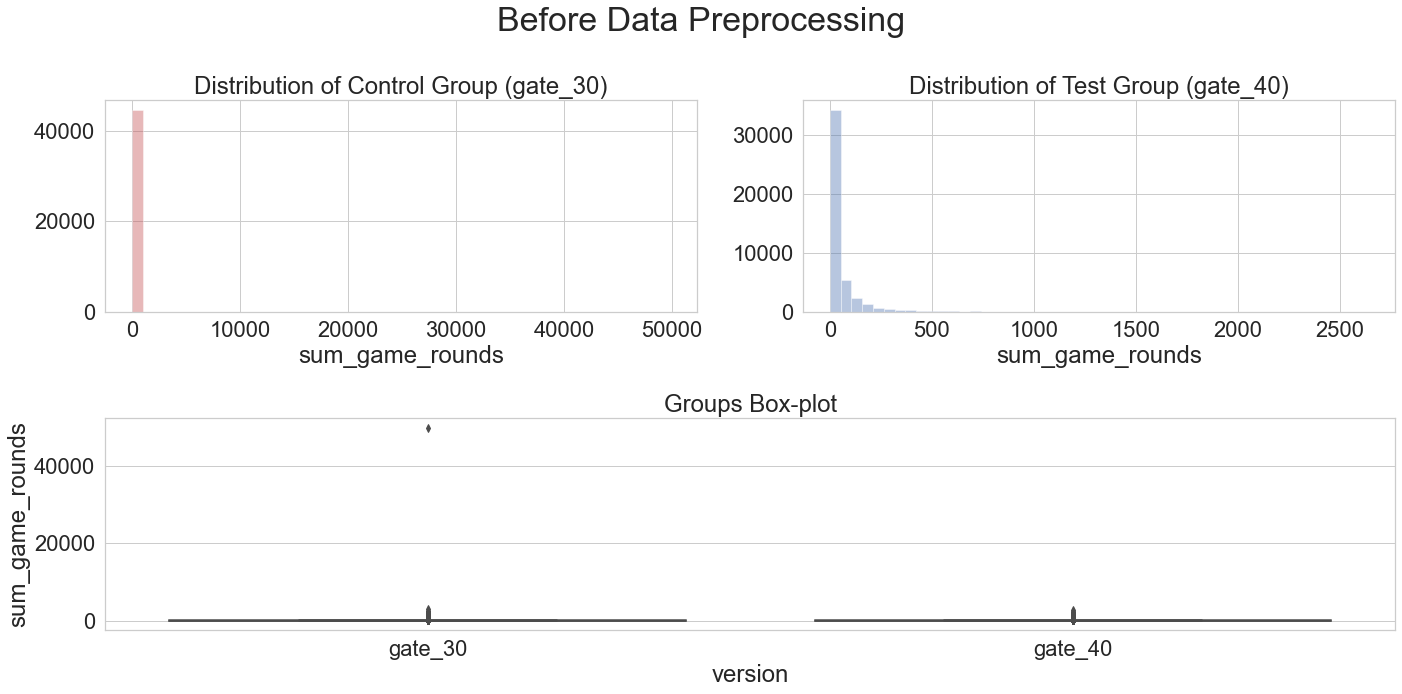

In [9]:
# First plot
ax1 = plt.subplot(221)
ax1.set_title('Distribution of Control Group (gate_30)')
sns.distplot(ab_cats.query('version == "gate_30"').sum_game_rounds, kde=False, color="r", ax=ax1)
#Second plot
ax2 = plt.subplot(222)
ax2.set_title('Distribution of Test Group (gate_40)')
sns.distplot(ab_cats.query('version == "gate_40"').sum_game_rounds, kde=False, color="b", ax=ax2)
# Third plot
ax3 = plt.subplot(212)
ax3.set_title('Groups Box-plot')
sns.boxplot(x=ab_cats.version, y=ab_cats.sum_game_rounds, ax=ax3)

plt.suptitle("Before Data Preprocessing", fontsize=34)
plt.tight_layout()

We've got the outlier in the control group and people with no experience in the game. Let's drop them.

In [10]:
ab_cats = ab_cats.drop(index=ab_cats.sum_game_rounds.idxmax())
ab_cats = ab_cats.query('sum_game_rounds > 0').reset_index(drop=True)

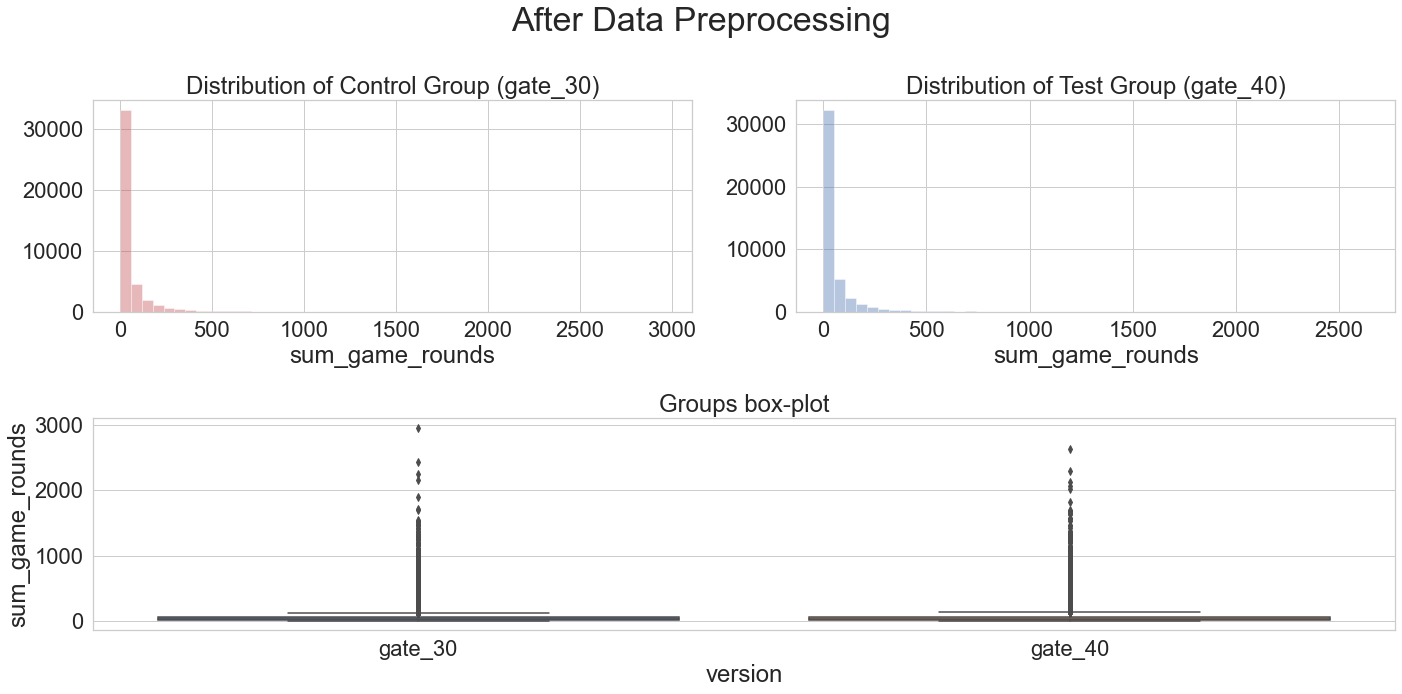

In [11]:
# First plot
ax1 = plt.subplot(221)
ax1.set_title('Distribution of Control Group (gate_30)')
sns.distplot(ab_cats.query('version == "gate_30"').sum_game_rounds, kde=False, color="r", ax=ax1)
#Second plot
ax2 = plt.subplot(222)
ax2.set_title('Distribution of Test Group (gate_40)')
sns.distplot(ab_cats.query('version == "gate_40"').sum_game_rounds, kde=False, color="b", ax=ax2)
# Third plot
ax3 = plt.subplot(212)
ax3.set_title('Groups box-plot')
sns.boxplot(x=ab_cats.version, y=ab_cats.sum_game_rounds, ax=ax3)

plt.suptitle("After Data Preprocessing", fontsize=34)
plt.tight_layout()

# 2 A/B Testing

Looking at the summary statistics and plots of variables by versions and comparing them with `sum_game_rounds`, we can find similarities between groups. However, it will be more helpful to see if there is a statistically significant difference.

There are several ways to AB-test:

* Parametric T-test;
* Non-parametric Mann Whitney U Test;
* Bootstrap.

In [12]:
# Divide our groups
a_cats = ab_cats.query('version == "gate_30"').sum_game_rounds
b_cats = ab_cats.query('version == "gate_40"').sum_game_rounds

In [13]:
# significance level
alpha = 0.05

## 2.1 T-test

Assumptions:

* Homogeneity of Variances (Levene Test);
* Variables Normal Distribution (Shapiro-Wilk Test).

In [14]:
l_h0 = 'Variances are homogeneous'
l_h1 = 'Variances are heterogeneous'
levene_test_p = stats.levene(a_cats, b_cats)[1]
levene_result = l_h0 if levene_test_p > alpha else l_h1
f'Levene Test: p_value={round(levene_test_p, 4)}. {levene_result}'

'Levene Test: p_value=0.6895. Variances are homogeneous'

Basing on plots, we can be sure that distributions of variables are not normal. But let's also confirm it by Shapiro-Wilk Test and Q-Q plots.

In [15]:
sw_h0 = 'Distribution is normal'
sw_h1 = 'Distribution is not normal'
sw_test_a_pval = stats.shapiro(a_cats)[1]
sw_test_b_pval = stats.shapiro(b_cats)[1]

In [16]:
sw_a_result = sw_h0 if sw_test_a_pval > alpha else sw_h1
f'Shapiro-Wilk Test For A Group: p_value={sw_test_a_pval}. {sw_a_result}'

'Shapiro-Wilk Test For A Group: p_value=0.0. Distribution is not normal'

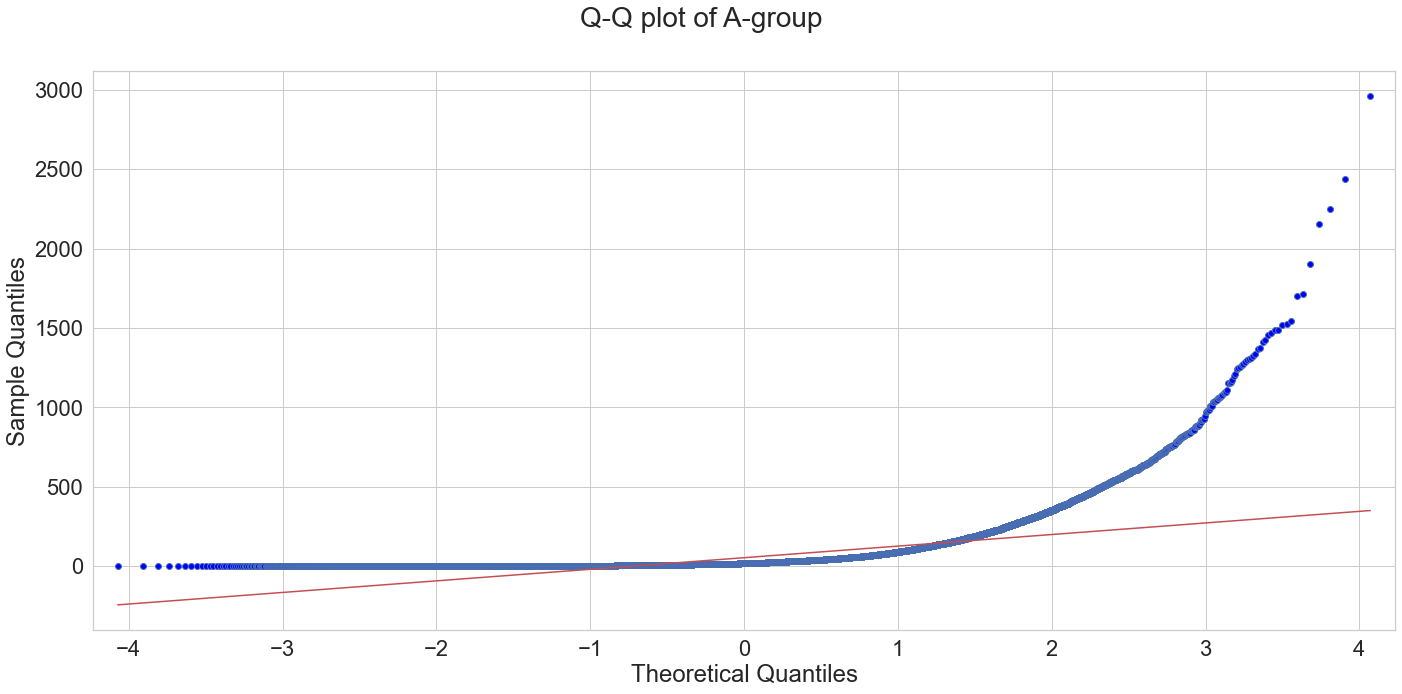

In [17]:
qq_a = sm.qqplot(a_cats, line='r')
plt.suptitle("Q-Q plot of A-group", fontsize=28)
plt.tight_layout()

In [18]:
sw_b_result = sw_h0 if sw_test_b_pval > alpha else sw_h1
f'Shapiro-Wilk Test For B Group: p_value={sw_test_b_pval}. {sw_b_result}'

'Shapiro-Wilk Test For B Group: p_value=0.0. Distribution is not normal'

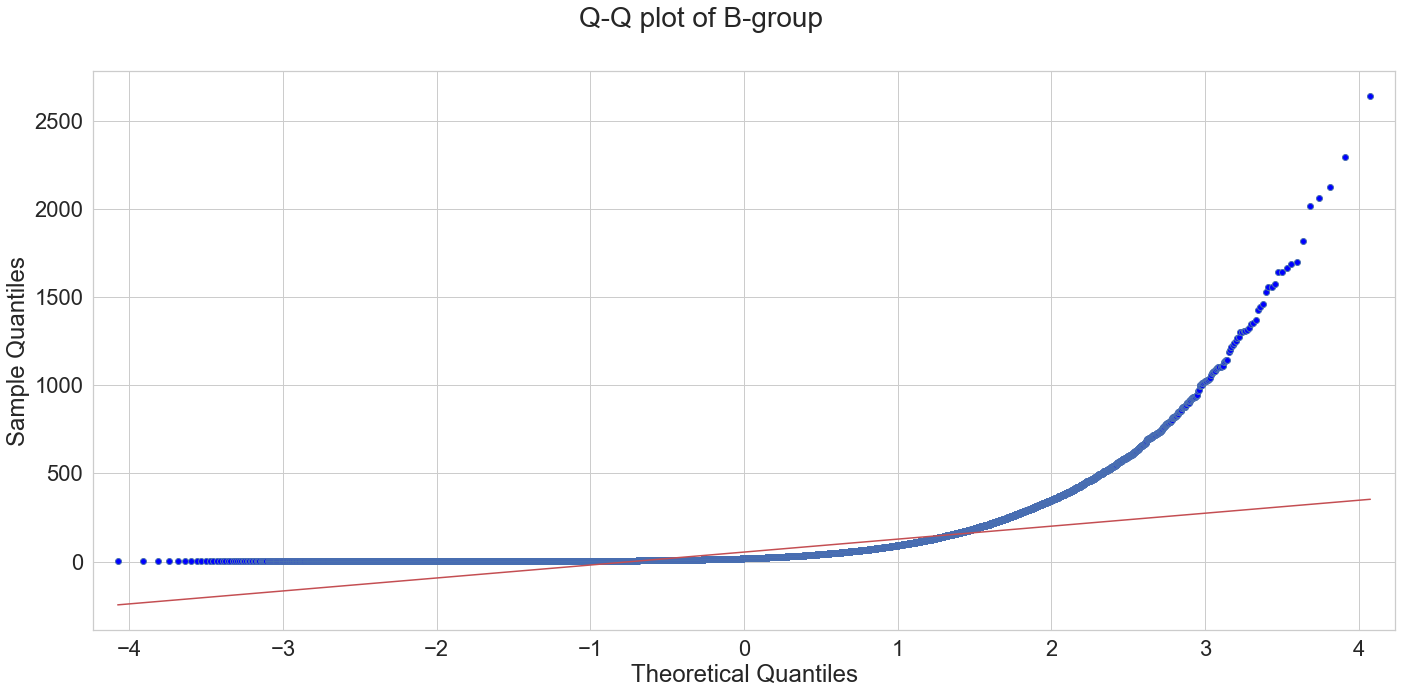

In [19]:
qq_b = sm.qqplot(b_cats, line='r')
plt.suptitle("Q-Q plot of B-group", fontsize=28)
plt.tight_layout()

The assumption of normal distribution of variables is violated. Therefore, we apply a non-parametric T-test analogue.

## 2.2 Mann Whitney U Test

In [20]:
mw_h0 = 'Means are equal. Groups do not differ'
mw_h1 = 'Means are not equal. Groups differ'
mw_test_pval = stats.mannwhitneyu(a_cats, b_cats)[1]
mw_result = mw_h0 if mw_test_pval > alpha else mw_h1
f'Mann Whitney U Test: p_value={round(mw_test_pval, 4)}. {mw_result}'

'Mann Whitney U Test: p_value=0.1177. Means are equal. Groups do not differ'

## 2.3 Bootstrap

Unlike standard statistical criteria, which work only with means, Bootstrap allows to test hypotheses and build confidence intervals for median or percentiles, etc.

How to bootstrap:

1. Build the bootstrap distribution of A and B;
2. Calculate their difference (matrix subtraction);
3. Сalculate the confidence interval in the resulting distribution;
4. If 0 value falls within the confidence interval, then the null hypothesis at a given significance level is accepted, otherwise it is rejected. 

In [21]:
def get_bootstrap(
    data_column_1, # first sample of numeric values
    data_column_2, # second sample of numeric values
    boot_it = 1000, # number of bootstrap subsamples
    statistic = np.mean, # statistics of interest
    bootstrap_conf_lvl = 0.95 # confidence level
):
    # 0) initialization
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    # 1) fetching subsamples
    for _ in range(boot_it): 
        # boot-sample from the first set
        samples_1 = data_column_1.sample(boot_len, replace=True).values
        # boot-sample from the second set
        samples_2 = data_column_2.sample(boot_len, replace=True).values
        # Adding statistics of differences between two samples
        boot_data.append(statistic(samples_1 - samples_2))
    
    # 2) set of boot-statistics and result
    pd_boot_data = pd.DataFrame(boot_data)
    # confidence interval
    left_quant = (1 - bootstrap_conf_lvl) / 2
    right_quant = 1 - (1 - bootstrap_conf_lvl) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    # p-value
    p_1 = stats.norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = stats.norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2 # two-sided hypothesis
    
    # 3) visualization
    plt.hist(pd_boot_data[0], bins=50)
    plt.style.use('bmh')
    plt.vlines(ci, ymin=0, ymax=150, linestyle='--', colors='black')
    plt.xlabel('boot_data', fontsize=22)
    plt.ylabel('frequency', fontsize=22)
    plt.title('Histogram of boot_data', fontsize=34)
    plt.show()

    return {'boot_data': boot_data, 'ci': ci, 'p_value': p_value}

### 2.3.1 Mean testing

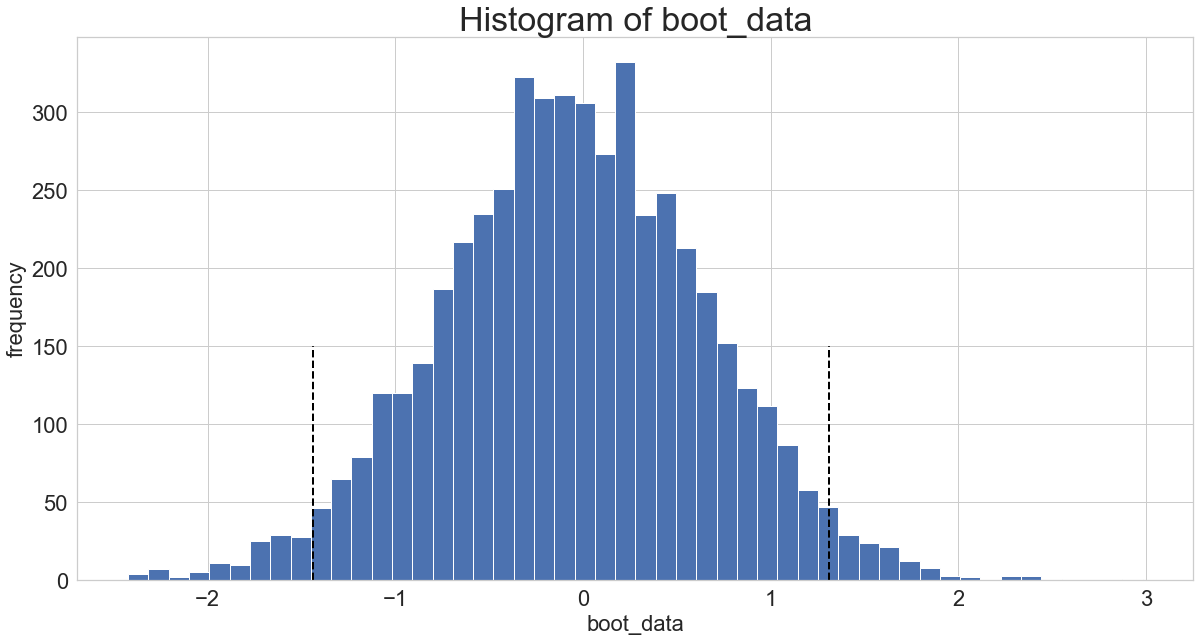

In [22]:
booted_data = get_bootstrap(a_cats, b_cats, 5000)

In [23]:
booted_data['p_value']

0.9437286746377544

In [24]:
booted_data['ci']

0
0.025 -1.439059
0.975  1.308905

### 2.3.2 Median testing

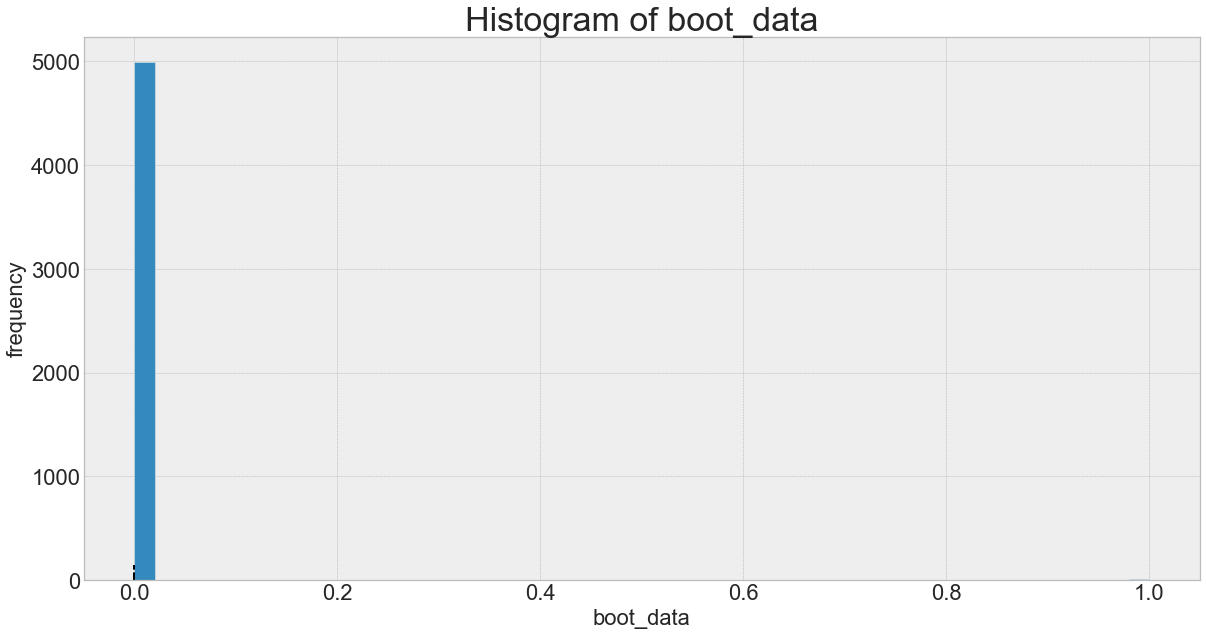

In [25]:
booted_data = get_bootstrap(a_cats, b_cats, 5000, np.median)

In [26]:
booted_data['p_value']

0.9642937079289102

Such an interesting plot is obtained since `sum_game_rounds` is the **discrete variable**.

# 3 Conclusion

Bootstrap сonfirmed there is not statistically significant difference between groups.